# Explore differential expression analysis results

In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import re
import pertpy as pt

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4iR1_Psomagen/'
experiment_name = 'CD4iR1_Psomagen'

## Read best Perturb-seq DE results

In [3]:
adata_de_wdonor = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')
adata_de = adata_de_wdonor[adata_de_wdonor.obs.culture_condition=='Rest'].copy()
# Annotate zscore
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.obs['target_contrast'].nunique()

8481

## Compare to Freimer et al arrayed RNA-seq

In [4]:
adata_freimer = sc.read_h5ad('../../metadata/Freimer_et_al_DEseq2.h5ad')
adata_freimer.layers['zscore'] = adata_freimer.layers['log_fc'] / adata_freimer.layers['lfcSE']
common_perturbations = np.intersect1d(adata_freimer.obs.target_gene, adata_de.obs['target_contrast_gene_name'])

In [5]:
thre = 0.05 # Significance threshold
# Only consider perturbations that have >=100 DE genes in either Freimer et al arrayed RNAseq or Perturb-seq dataset
sig_number = np.zeros(len(common_perturbations))
for i, g in enumerate(common_perturbations):
    freimer_set = set(adata_freimer[:,adata_freimer[adata_freimer.obs['target_gene']==g].layers['adj_p_value']<thre].var.gene_id)
    perturbseq_set = set(adata_de[:,adata_de[adata_de.obs['target_contrast_gene_name']==g].layers['adj_p_value']<thre].var.gene_ids)
    sig_number[i] = len(freimer_set | perturbseq_set)
sig_number = sig_number.astype(int)
common_sig_perturbations = common_perturbations[sig_number>=100]

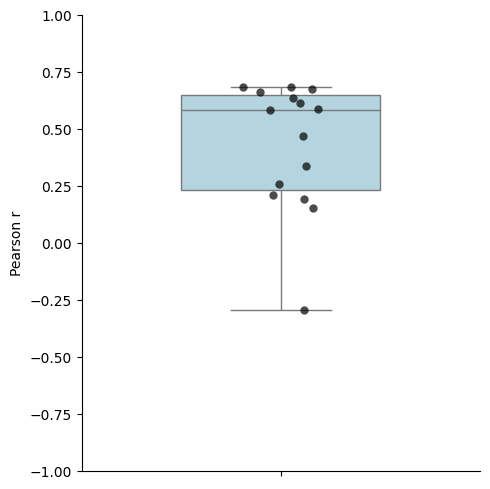

In [7]:
rest_signif_corr_all = np.zeros([len(common_sig_perturbations),2])

for i, g in enumerate(common_sig_perturbations):
    # Get data for this perturbation
    gwt_effect_g = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='zscore')
    gwt_effect_g.columns = ['perturbseq_zscore']
    gwt_effect_g['perturbseq_signif'] = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='adj_p_value')
    freimer_effect_g = sc.get.var_df(adata_freimer, adata_freimer.obs_names[adata_freimer.obs['target_gene'] == g].tolist(), layer='zscore')
    freimer_effect_g.columns = ['freimer_zscore']
    freimer_effect_g['freimer_signif'] = sc.get.var_df(adata_freimer, adata_freimer.obs_names[adata_freimer.obs['target_gene'] == g].tolist(), layer='adj_p_value')

    concat_df = pd.concat([freimer_effect_g, gwt_effect_g], axis=1).dropna()

    # Calculate correlation coefficients and p-values for Rest condition only
    rest_signif_corr, rest_signif_pval = scipy.stats.pearsonr(
        concat_df[concat_df['freimer_signif']<thre]['freimer_zscore'], 
        concat_df[concat_df['freimer_signif']<thre]['perturbseq_zscore']
    ) if sum(concat_df['freimer_signif']<thre) > 1 else (float('nan'), float('nan'))
    #rest_signif_corr, rest_signif_pval = scipy.stats.pearsonr(

    rest_signif_corr_all[i,0] = rest_signif_corr
    rest_signif_corr_all[i,1] = rest_signif_pval

# Create a simple DataFrame
df = pd.DataFrame({'r': rest_signif_corr_all[:,0], 'pvalue': rest_signif_corr_all[:,1]})

fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(data=df, y='r', color='lightblue', width=0.5, ax=ax)
sns.stripplot(data=df, y='r', color='black', size=6, jitter=True, alpha=0.7, ax=ax)

ax.set_ylabel("Pearson r")
ax.set_ylim(-1, 1)  # since r ranges from -1 to 1

sns.despine()
plt.tight_layout()
plt.show()

## Compare to Weinstock et al arrayed RNA-seq

In [8]:
weinstock_df = pd.read_csv('../../metadata/TableS4_weinstock_et_al_DE.csv')
weinstock_kos = weinstock_df['KO'].unique().tolist()
common_perturbations = np.intersect1d(weinstock_kos, adata_de[adata_de.obs.culture_condition == 'Rest'].obs['target_contrast_gene_name'])
weinstock_df['zscore'] = weinstock_df['log2FoldChange'] / weinstock_df['lfcSE']
weinstock_df['gene_id'] = weinstock_df['gene_id'].str.split('.').str[0]

In [9]:
thre = 0.05 # Significance threshold
# Only consider perturbations that have >=100 DE genes in either Weinstock et al arrayed RNAseq or Perturb-seq dataset
sig_number = np.zeros(len(common_perturbations))
for i, g in enumerate(common_perturbations):
    weinstock_set = set(weinstock_df[(weinstock_df['KO'] == g)&(weinstock_df.padj<thre)].gene_id) 
    perturbseq_set = set(adata_de[:,adata_de[adata_de.obs['target_contrast_gene_name']==g].layers['adj_p_value']<thre].var.gene_ids)
    sig_number[i] = len(weinstock_set | perturbseq_set)
sig_number = sig_number.astype(int)
common_sig_perturbations = common_perturbations[sig_number>=100]